In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from cohlib.utils import pickle_open, logistic, draw_raster_single
from cohlib.plot import draw_raster_single

In [3]:
def plot_synthetic_data(L, sample_length, C, seed, mu, fs=1000, start=0):
    T = sample_length/fs
    trange = [0,T]
    data_path = f'saved/synthetic_data/simple_synthetic_{L}_{sample_length}_{C}_{mu}_{seed}'

    data_load = pickle_open(data_path)

    spikes = data_load['observed']['spikes']

    Gamma = data_load['latent']['Gamma']
    xs = data_load['latent']['xs']
    vs = data_load['latent']['vs']
    zs = data_load['latent']['zs']
    lams = data_load['observed']['lams']

    freqs = data_load['meta']['freqs']

    swap = False
    ls = [0,1,2]
    fig,ax = plt.subplots(6,1,figsize=(12,10), sharex=True)
    ls = [l + start for l in ls]
    title_size = 16
    label_size = 14
    x = np.arange(0, sample_length) / 1000
    # for i in range(start,start+3):
    colors = ['tab:blue', 'tab:orange', 'tab:green']
    for i, l in enumerate(ls):
    # i = 3
        ax[1].plot(x, xs[l,1,:], color=colors[i])
        # ax[1].set_ylim([-1,1])
        ax[1].margins(0)
        ax[1].set_title(r'$x_t^{2, \ell}$  $\ell = (1,2,3)$', size=title_size)
        ax[1].set_ylabel('mV', size = label_size)
        
        ax[0].plot(x, xs[l,0,:], color=colors[i])
        # ax[0].set_ylim([-1,1])
        ax[0].margins(0)
        ax[0].set_title(r'$x_t^{1, \ell}$  $\ell = (1,2,3)$', size=title_size)
        ax[0].set_ylabel('mV', size = label_size)
        
        ax[2].plot(x, lams[l,0,:], color=colors[i])
        ax[2].set_title(r'$\lambda_t^{1, c,\ell}$   $c = 1$  $\ell = (1,2,3)$', size=title_size)
        ax[2].margins(0)
        ax[2].set_ylabel('Intensity', size = label_size)

        ax[3].plot(x, lams[l,1,:], color=colors[i])
        ax[3].set_title(r'$\lambda_t^{2, c,\ell}$   $c = 1$  $\ell = (1,2,3)$', size=title_size)
        ax[3].margins(0)
        ax[3].set_ylabel('Intensity', size = label_size)
    # draw_raster_single(spikes[start,:,:], trange=[0,0.5], region='CPB', override_bg_color='white',ax=ax[3])
    color = colors[0]
    spike_matA = spikes[ls[0],:,0,:]
    spike_matB = spikes[ls[0],:,1,:]
    draw_raster_single(spike_matA, trange=trange, color_name=color, ax=ax[4])
    draw_raster_single(spike_matB, trange=trange, color_name=color, ax=ax[5])
    ax[4].set_title(r'$n_t^{1, c,\ell}$   $c = (1, ..., C)$   $\ell = 1$', size=title_size)
    ax[5].set_title(r'$n_t^{2, c,\ell}$   $c = (1, ..., C)$   $\ell = 1$', size=title_size)
    ax[4].set_ylabel('Spikes A', size = label_size)
    ax[5].set_ylabel('Spikes B', size = label_size)

    ax[5].set_xlabel('Time (sec)', size = label_size)
    plt.xlim([0,sample_length/fs])
    plt.tight_layout()

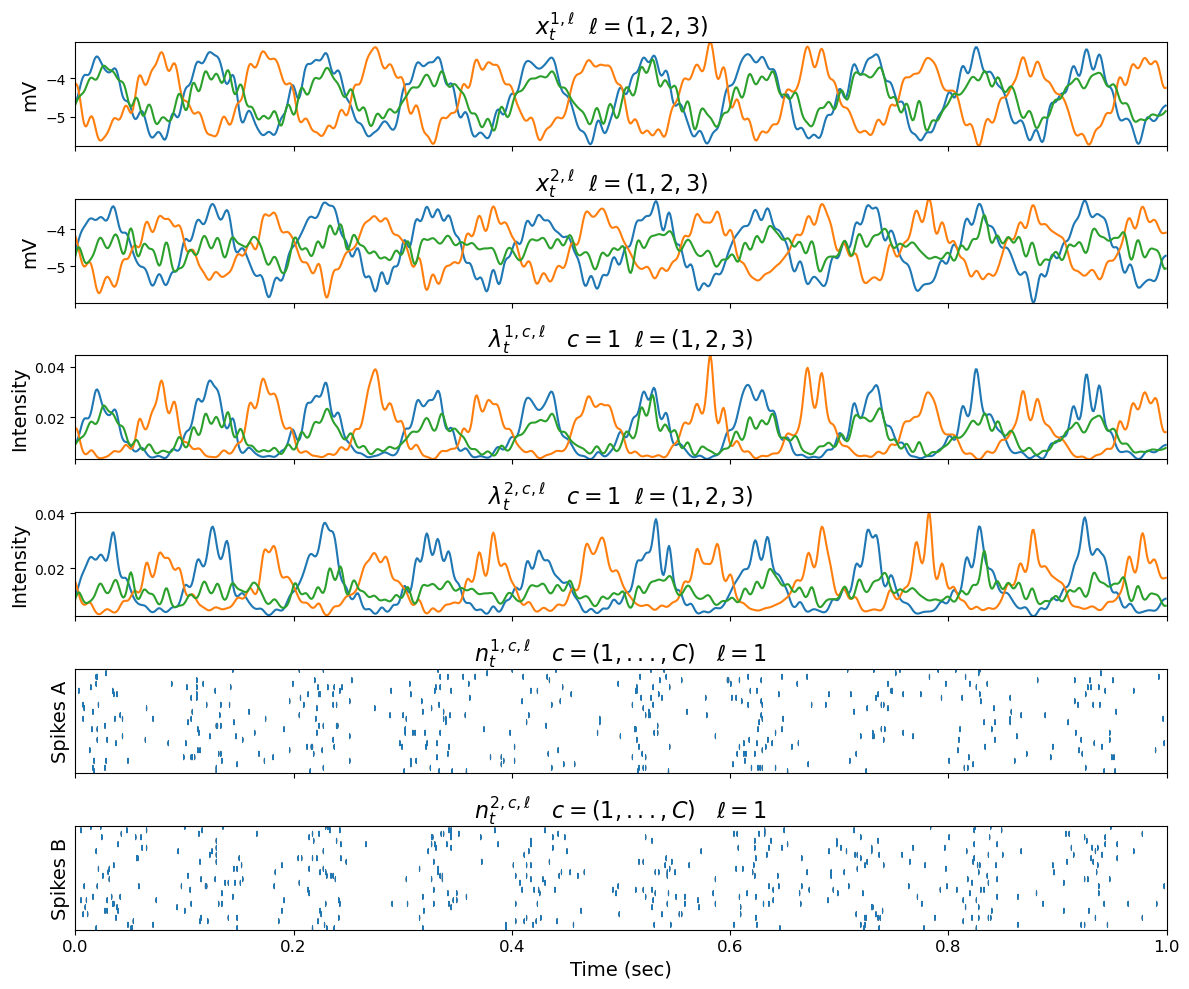

In [4]:
mu = -4.5
L = 25 
C = 30
sample_length = 1000
seed = 8
plot_synthetic_data(L, sample_length, C, seed, mu, 
start=12)



In [5]:
data_path = f'saved/synthetic_data/simple_synthetic_{L}_{sample_length}_{C}_{mu}_{seed}'
model_path = f'saved/fitted_models/simple_synthetic_{L}_{sample_length}_{C}_{mu}_{seed}_fitted'

data_load = pickle_open(data_path)
model_load = pickle_open(model_path)

In [6]:
spikes = data_load['observed']['spikes']
lams = data_load['observed']['lams']
Gamma_true = data_load['latent']['Gamma']
xs = data_load['latent']['xs']
vs = data_load['latent']['vs']
zs = data_load['latent']['zs']
Wv_data = data_load['meta']['Wv']
freqs = data_load['meta']['freqs']

Wv_model = model_load['Wv']
Wv = Wv_model

In [7]:
1/(1+np.exp(xs.max()))
lams.max()

0.24500704171475005

### We want to do two things
1) Using true Gamma, confirm that construction of 'full' and 'real' Gamma is doing what we want it to do
2) Construct a `Gamma_inv_init` that is the true data generating Gamma
   - we will use this to initialize fitting algorithm to help diagnose what's going wrong


In [8]:
Gamma_true.shape

(500, 2, 2)

Our true $\Gamma_j$ is shape $(J, K, K)$. It does not include the DC component, and is not in the form of a coviarance matrix. So to build $\Gamma_v$ we need to convert $\Gamma_j$ into $\Gamma_{v,j}$, combine with DC component, and then convert to $\Gamma_v$ of shape $(K\cdot(2J+1),K\cdot(2J+1))$. 

Then, we'll confirm that we've done this correctly by taking $\sum_{\ell=1}^L v^{\ell} {v^{\ell}}^{\top}$ and confirming it is close to $\Gamma_v$.  

Hopefully this catches any errors if they currently exist, and then we can use our true $\Gamma_v$ to initialize the fitting algorithm. 

In [7]:
from cohlib.alg.em_sgc import reverse_rearrange_mat, transform_cov_c2r
J = Gamma_true.shape[0]
num_J_vars = J*2 + 1
K = Gamma_true.shape[1]

Gamma_real_ri_ord = np.stack([transform_cov_c2r(Gamma_true[j,:,:]) for j in range(J)])
Gamma_real_k_ord = np.stack([reverse_rearrange_mat(Gamma_real_ri_ord[j,:,:], K) for j in range(J)])

how should this relate to complex version? how do we have $v$ ordered in alg? 

Let (omitting trial ind) $v^k = (v^k_{j=1}, \ldots v^k_{j=J})$ then we should have $v = (v^{k=1}, \ldots, v^{k=K})$

In [8]:
from scipy.linalg import block_diag
print(np.round(Gamma_real_ri_ord[0,:,:], 5))
print(np.round(Gamma_true[0,:,:], 5))
print(np.round(Gamma_true[0,:,:].real/2, 5))


print(np.round(Gamma_real_k_ord[0,:2,:2], 5))
print(np.round(Gamma_real_k_ord[1,:2,:2], 5))

diag_real1 = [Gamma_real_k_ord[j,:2,:2] for j in range(J)]
diag_real2 = [Gamma_real_k_ord[j,2:,2:] for j in range(J)]
diag_real_list = diag_real1 + diag_real2
diag_real_true = np.diag(block_diag(*diag_real_list))

[[ 0.24538  0.00312 -0.      -0.00418]
 [ 0.00312  0.75164  0.00418 -0.     ]
 [ 0.       0.00418  0.24538  0.00312]
 [-0.00418  0.       0.00312  0.75164]]
[[0.49076+0.j      0.00624+0.00836j]
 [0.00624-0.00836j 1.50329+0.j     ]]
[[0.24538 0.00312]
 [0.00312 0.75164]]
[[ 0.24538 -0.     ]
 [ 0.       0.24538]]
[[ 0.29276 -0.     ]
 [ 0.       0.29276]]


In [9]:
# def construct_Gamma_full_real_dc_nocomplex(DC_update, Gamma_update_real, K, num_J_vars, Gamma_inv_init, invert=False):
#     J = int((num_J_vars-1)/2)

#     temp = DC_update

#     Gamma_full = np.zeros((K*num_J_vars, K*num_J_vars))
#     if invert is True:
#         if DC_update.sum() != 0:
#             DC_update = np.linalg.inv(DC_update)
#             # DC_update = transform_cov_r2c(np.linalg.inv(transform_cov_c2r(DC_update))).real
#     base_filt = np.zeros(num_J_vars)
#     base_filt[0] = 1
#     j_filt = np.tile(base_filt.astype(bool), K)

#     for k in range(K):
#         Gamma_full[j_filt,k*num_J_vars] = DC_update[:,k]


#     # Gamma_update_real_inv = np.stack([np.linalg.inv(Gamma_update_real[j]) for j in range(J)])

#     for j in range(J):
#         Gamma_j = Gamma_update_real[j,:,:]
#         if invert is True:
#             Gamma_j = np.linalg.inv(Gamma_j)
#         # Gamma_n_real = reverse_rearrange_mat(transform_cov_c2r(Gamma_n),K)
#         base_filt = np.zeros(num_J_vars)
#         j_var = int(j*2 + 1)
#         base_filt[j_var:j_var+2] = 1
#         j_filt = np.tile(base_filt.astype(bool), K)
#         # print(j_filt)
#         for k in range(K):
#             kj = int(k*2)
#             Gamma_full[j_filt,k*num_J_vars+j_var:k*num_J_vars+j_var+2] = Gamma_j[:,kj:kj+2]

#     return Gamma_full

In [9]:
from cohlib.utils import get_dcval
dc_real = get_dcval(mu,J+1,'real')
dc_real

-358.814819200678

In [10]:
# ahhh there could be a problem related to this
# our 'mu -> dc' is what the vector needs to be, 
    # but not what the component in Gamma needs to be
DC_true = np.diag(np.array([dc_real, dc_real]))**2
DC_true

array([[128748.07447802,      0.        ],
       [     0.        , 128748.07447802]])

In [12]:
from cohlib.alg.em_sgc import construct_Gamma_full_real_dc
Gamma_full_realdc = construct_Gamma_full_real_dc(DC_true, Gamma_true, K, num_J_vars, None)

In [13]:
diag_nodc_construct = np.delete(np.diag(Gamma_full_realdc), (0,num_J_vars), axis=0)
np.all(np.isclose(diag_real_true, diag_nodc_construct))

True

In [14]:
upperright = Gamma_full_realdc[1:num_J_vars, num_J_vars+1:]
j = 3
print(Gamma_real_k_ord[j,:2,2:])
print(upperright[2*j:2*j+2, 2*j:2*j+2])

[[ 0.00100841  0.00227284]
 [-0.00227284  0.00100841]]
[[ 0.00100841  0.00227284]
 [-0.00227284  0.00100841]]


In [15]:
upperleft = Gamma_full_realdc[1:num_J_vars, 1:num_J_vars]
j = 3
print(Gamma_real_k_ord[j,:2,:2])
print(upperleft[2*j:2*j+2, 2*j:2*j+2])

[[ 0.39385216 -0.        ]
 [ 0.          0.39385216]]
[[ 0.39385216 -0.        ]
 [ 0.          0.39385216]]


In [16]:
bottomright = Gamma_full_realdc[num_J_vars+1:, num_J_vars+1:]
j = 9
print(Gamma_real_k_ord[j,2:,2:])
print(bottomright[2*j:2*j+2, 2*j:2*j+2])

[[750.  -0.]
 [  0. 750.]]
[[750.  -0.]
 [  0. 750.]]


In [17]:
from cohlib.utils import conv_v_to_z
def Gamma_est_from_zs(zs, dc=True):
    if dc is True:
        zs_outer = np.einsum('ijk,imk->kjmi', zs[:,:,1:], zs[:,:,1:].conj())
    else:
        zs_outer = np.einsum('ijk,imk->kjmi', zs, zs.conj())
    zs_outer_mean = zs_outer.mean(3)
    return zs_outer_mean


zvs = conv_v_to_z(vs[:,:,1:], axis=2,dc=False)
Gamma_est_zv = Gamma_est_from_zs(zvs, dc=False)
np.all(np.isclose(zs[:,:,1:], zvs))

True

In [18]:
j = 9
print(np.round(Gamma_est_zv[j,:,:],4))
print(np.round(Gamma_true[j,:,:], 4))

[[1276.9057  +0.j     1107.7188-374.6527j]
 [1107.7188+374.6527j 1291.6608  +0.j    ]]
[[1500.      +0.j     1271.6202-536.0804j]
 [1271.6202+536.0804j 1500.      +0.j    ]]


In [44]:
# from cohlib.alg.em_sgc import get_freq_vecs_real_dc
# def update_Gamma_real_dc(mus, Ups_invs, K, num_J_vars, dc=True):
#     L = mus.shape[0]
#     if dc is True:
#         J_nodc = int((num_J_vars-1)/2)
#         J = J_nodc 
#     else:
#         # J = int(num_J_vars/2)
#         raise NotImplementedError

#     DC_mus_outer = np.zeros((L,K,K))
#     # DC_Upss = np.zeros((L,K,K))
#     mus_outer = np.zeros((L,J,K*2,K*2))
#     # Upss = np.zeros((L,J,K*2,K*2))

#     for l in range(L):
#         # Ups_inv_j_vecs = get_freq_vecs_real_dc(np.diag(Ups_invs[l,:,:]), K, num_J_vars)
#         mu_js = get_freq_vecs_real_dc(mus[l,:], K,num_J_vars)

#         DC_mus_outer[l,:,:] = np.outer(mu_js[0], mu_js[0])
#         # DC_Upss[l,:,:] = -np.diag(1/Ups_inv_j_vecs[0])
#         for j in range(J):
#             mus_outer[l,j,:,:] = np.outer(mu_js[j+1], mu_js[j+1])
#             # Upss[l,j,:,:] = -np.diag(1/Ups_inv_j_vecs[j+1])
#     # enforce circulary symmetry
#     k_mask_pre = 1 - np.eye(2)
#     k_mask_inv = block_diag(*[k_mask_pre for k in range(K)])
#     k_mask =  1 - k_mask_inv

#     # Gamma_update_real = (mus_outer*k_mask[None,None,:,:]).sum(0) + Upss.sum(0)
#     Gamma_update_real = (mus_outer*k_mask[None,None,:,:]).sum(0) 
#     Gamma_update_real = Gamma_update_real / L

#     DC_update = np.zeros((K,K))
#     for l in range(L):
#         # DC = DC_mus_outer[l,:,:] + DC_Upss[l,:,:]
#         DC = DC_mus_outer[l,:,:] 
#         DC_update += DC
#     DC_update = DC_update / L
#     # DC_update = np.diag(np.diag(DC_update))

#     return DC_update, Gamma_update_real

In [19]:
mus_v = vs.reshape(L, K*vs.shape[2])
# DC_update, Gamma_update_real = update_Gamma_real_dc(mus_v, None, K, num_J_vars)

In [29]:
# j = 20
# # print(np.round(Gamma_update_real[j,:,:],4))
# # print(np.round(Gamma_real_k_ord[j,:,:],4))
# print(np.round(Gamma_update_real[j,:,:],4) / np.round(Gamma_real_k_ord[j,:,:],4))

In [22]:
from cohlib.alg.em_sgc import est_cov_r2c, rearrange_mat, update_Gamma_complex_dc, get_freq_vecs_real_dc
def update_Gamma_complex_dc(mus, Ups_invs, K, num_J_vars, dc=True):
    L = mus.shape[0]
    if dc is True:
        J_nodc = int((num_J_vars-1)/2)
        J = J_nodc 
    else:
        # J = int(num_J_vars/2)
        raise NotImplementedError

    DC_mus_outer = np.zeros((L,K,K))
    DC_Upss = np.zeros((L,K,K))
    mus_outer = np.zeros((L,J,K*2,K*2))
    Upss = np.zeros((L,J,K*2,K*2))

    for l in range(L):
        # Ups_inv_j_vecs = get_freq_vecs_real_dc(np.diag(Ups_invs[l,:,:]), K, num_J_vars)
        mu_js = get_freq_vecs_real_dc(mus[l,:], K,num_J_vars)

        DC_mus_outer[l,:,:] = np.outer(mu_js[0], mu_js[0])
        # DC_Upss[l,:,:] = np.diag(1/Ups_inv_j_vecs[0])
        for j in range(J):
            mus_outer[l,j,:,:] = np.outer(mu_js[j+1], mu_js[j+1])
            # Upss[l,j,:,:] = -np.diag(1/Ups_inv_j_vecs[j+1])

    # enforce circulary symmetry
    k_mask_pre = 1 - np.eye(2)
    k_mask_inv = block_diag(*[k_mask_pre for k in range(K)])
    k_mask =  1 - k_mask_inv

    DC_update = np.zeros((K,K))
    Gamma_update_complex = np.zeros((J,K,K), dtype=complex)
    for l in range(L):
        DC = DC_mus_outer[l,:,:] + DC_Upss[l,:,:]
        Sig_real = mus_outer[l,:,:,:]*k_mask + Upss[l,:,:,:]
        Sig_complex = np.zeros((J,K,K), dtype=complex)

        for j in range(J):
            Sig_complex[j,:,:] = est_cov_r2c(rearrange_mat(Sig_real[j,:,:],K))

        DC_update += DC
        Gamma_update_complex += Sig_complex
    DC_update = DC_update / L
    # Gamma_update_complex = (1/4)*Gamma_update_complex / L
    Gamma_update_complex = Gamma_update_complex / L

    return DC_update, Gamma_update_complex
# def update_Gamma_complex_dc(mus, Ups_invs, K, num_J_vars, dc=True):
#     L = mus.shape[0]
#     if dc is True:
#         J_nodc = int((num_J_vars-1)/2)
#         J = J_nodc 
#     else:
#         # J = int(num_J_vars/2)
#         raise NotImplementedError

#     DC_mus_outer = np.zeros((L,K,K))
#     # DC_Upss = np.zeros((L,K,K))
#     mus_outer = np.zeros((L,J,K*2,K*2))
#     # Upss = np.zeros((L,J,K*2,K*2))

#     for l in range(L):
#         # Ups_inv_j_vecs = get_freq_vecs_real_dc(np.diag(Ups_invs[l,:,:]), K, num_J_vars)
#         mu_js = get_freq_vecs_real_dc(mus[l,:], K,num_J_vars)

#         DC_mus_outer[l,:,:] = np.outer(mu_js[0], mu_js[0])
#         # DC_Upss[l,:,:] = np.diag(1/Ups_inv_j_vecs[0])
#         for j in range(J):
#             mus_outer[l,j,:,:] = np.outer(mu_js[j+1], mu_js[j+1])
#             # Upss[l,j,:,:] = -np.diag(1/Ups_inv_j_vecs[j+1])

#     # enforce circulary symmetry
#     k_mask_pre = 1 - np.eye(2)
#     k_mask_inv = block_diag(*[k_mask_pre for k in range(K)])
#     k_mask =  1 - k_mask_inv

#     DC_update = np.zeros((K,K))
#     Gamma_update_complex = np.zeros((J,K,K), dtype=complex)
#     for l in range(L):
#         # DC = DC_mus_outer[l,:,:] + DC_Upss[l,:,:]
#         DC = DC_mus_outer[l,:,:] #+ DC_Upss[l,:,:]
#         # Sig_real = mus_outer[l,:,:,:]*k_mask + Upss[l,:,:,:]
#         Sig_real = mus_outer[l,:,:,:]*k_mask #+ Upss[l,:,:,:]
#         Sig_complex = np.zeros((J,K,K), dtype=complex)

#         for j in range(J):
#             Sig_complex[j,:,:] = est_cov_r2c(rearrange_mat(Sig_real[j,:,:],K))

#         DC_update += DC
#         Gamma_update_complex += Sig_complex
#     DC_update = DC_update / L
#     Gamma_update_complex = Gamma_update_complex / L

#     # DC_update = np.array([[1, 0], [0, 1]])

#     return DC_update, Gamma_update_complex

In [23]:
DC_update_complex, Gamma_update_complex = update_Gamma_complex_dc(mus_v, None, K, num_J_vars)

In [24]:
DC_update_complex

array([[128234.62304733, 128234.62304733],
       [128234.62304733, 128234.62304733]])

In [25]:
j = 9 
print(np.round(Gamma_update_complex[j,:,:],4))
print(np.round(Gamma_est_zv[j,:,:],4))
print(np.round(Gamma_true[j,:,:], 4))

[[5107.6227   +0.j     4430.8752-1498.6109j]
 [4430.8752+1498.6109j 5166.6432   +0.j    ]]
[[1276.9057  +0.j     1107.7188-374.6527j]
 [1107.7188+374.6527j 1291.6608  +0.j    ]]
[[1500.      +0.j     1271.6202-536.0804j]
 [1271.6202+536.0804j 1500.      +0.j    ]]


In [40]:
def construct_Gamma_full_real_dc(DC_update, Gamma_update_complex, K, num_J_vars, invert=False):
    J = int((num_J_vars-1)/2)


    Gamma_full = np.zeros((K*num_J_vars, K*num_J_vars))
    if invert is True:
        DC_update = np.linalg.inv(DC_update)
    base_filt = np.zeros(num_J_vars)
    base_filt[0] = 1
    j_filt = np.tile(base_filt.astype(bool), K)

    for k in range(K):
        Gamma_full[j_filt,k*num_J_vars] = DC_update[:,k]



    for j in range(J):
        Gamma_n = Gamma_update_complex[j,:,:]
        if invert is True:
            Gamma_n = np.linalg.inv(Gamma_n)
        Gamma_n_real = reverse_rearrange_mat(transform_cov_c2r(Gamma_n),K)
        base_filt = np.zeros(num_J_vars)
        j_var = int(j*2 + 1)
        base_filt[j_var:j_var+2] = 1
        j_filt = np.tile(base_filt.astype(bool), K)
        # print(j_filt)
        for k in range(K):
            kj = int(k*2)
            Gamma_full[j_filt,k*num_J_vars+j_var:k*num_J_vars+j_var+2] = Gamma_n_real[:,kj:kj+2]

    return Gamma_full

In [41]:
test = construct_Gamma_full_real_dc(DC_true, Gamma_true, K, num_J_vars)

In [42]:
np.all(test == Gamma_full_realdc)

True

In [45]:
def Gamma_full_real_to_Gamma_real(Gamma_full_real, K, num_J_vars, DC=True):
    if DC is True:
        DC = np.zeros((K,K))
        base_filt = np.zeros(num_J_vars)
        base_filt[0] = 1
        j_filt = np.tile(base_filt.astype(bool), K)

        for k in range(K):
            DC[:,k] = Gamma_full_real[j_filt,k*num_J_vars]

        Gamma_reduced_real = np.zeros((J, 2*K, 2*K))
        base_filt = np.zeros(num_J_vars)

        for j in range(J):
            j_var = int(j*2 + 1)
            base_filt = np.zeros(num_J_vars)
            base_filt[j_var:j_var+2] = 1
            j_filt = np.tile(base_filt.astype(bool), K)
            # print(j_filt)

            for k in range(K):
                kj = int(k*2)
                # Gamma_full[j_filt,k*num_J_vars+j_var:k*num_J_vars+j_var+2] = Gamma_n_real[:,kj:kj+2]
                Gamma_reduced_real[j,:,kj:kj+2] = Gamma_full_real[j_filt,k*num_J_vars+j_var:k*num_J_vars+j_var+2]
        
        return DC, Gamma_reduced_real

    else: 
        raise NotImplementedError

In [46]:
testdc, test = Gamma_full_real_to_Gamma_real(Gamma_full_realdc, K, num_J_vars)
np.all(test == Gamma_real_k_ord)

True

In [47]:
from cohlib.alg.em_sgc import transform_cov_r2c
Gamma_true_inv = np.stack([np.linalg.inv(Gamma_true[j,:,:]) for j in range(J)])
test_init = construct_Gamma_full_real_dc(np.diag(1/np.diag(DC_true)), Gamma_true_inv, K, num_J_vars, invert=False)
DC, test_init_reduce = Gamma_full_real_to_Gamma_real(test_init, K, num_J_vars)
confirm = np.stack([transform_cov_r2c(reverse_rearrange_mat(test_init_reduce[j,:,:],K)) for j in range(J)])
np.all(Gamma_true_inv == confirm)

True

In [239]:
Gamma_true_inv_real_ri_ord = np.stack([transform_cov_c2r(Gamma_true_inv[j,:,:]) for j in range(J)])
Gamma_true_inv_real_k_ord = np.stack([reverse_rearrange_mat(Gamma_true_inv_real_ri_ord[j,:,:], K) for j in range(J)])
test1 = np.stack([rearrange_mat(Gamma_true_inv_real_k_ord[j,:,:], K) for j in range(J)])
test2 = np.stack([transform_cov_r2c(test1[j,:,:]) for j in range(J)])
np.all(Gamma_true_inv == test2)

True